In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import csv
import math
import matplotlib.pyplot as plt

In [ ]:
!pip install python-louvain
import community.community_louvain as cl

In [ ]:
import community
import matplotlib.cm as cm

## Расчёт уровня инфраструктурной обеспеченности (F)


In [ ]:
import pickle

# Чтение CSV-файла с данными о сервисах
df_services_new = pd.read_csv('infrastructure_31.csv', delimiter=';', index_col=0) # Файл с деревнями и городами этого района

# Чтение матрицы времен из pickle-файла
with open('result_matrix_cold_3.pkl', 'rb') as f:
    time_matrix_new = pickle.load(f)
df_services_new

,school,kindergarten,post,library,culture,atm,health,port,airport,shop
name,,,,,,,,,,
Кепервеем,1,0,1,1,1,0,1,0,1,0
Илирней,1,1,1,1,1,0,1,0,1,0
Островное,1,0,1,1,1,1,1,0,1,0
Анюйск,1,0,1,1,1,0,2,1,1,1
Омолон,1,0,1,1,1,2,2,0,1,1
Черский,1,2,1,1,1,1,3,1,1,9
Нижнеколымск,0,0,0,0,0,0,0,1,0,0
Колымское,1,1,1,1,1,0,2,1,1,1
Андрюшкино,1,1,1,1,1,0,2,0,1,0


In [ ]:
#Задать время
t=20
# Преобразование индекса матрицы времен к формату DataFrame
index = df_services_new.index
time_df = pd.DataFrame(time_matrix_new, index=index, columns=index)

# Создание новой пустой таблицы с теми же индексами и колонками, что и исходная
new_df = df_services_new.copy()
new_df[:] = 0

# Создаем новый датафрейм для записи названий деревень и предоставляемых ими сервисов
village_service_providers = pd.DataFrame(columns=['Деревня', 'Сервис'])

# Обновление значений в новой таблице
for village in new_df.index:
    # Находим все деревни, до которых можно добраться за <= t
    reachable_villages = time_df[village][(time_df[village] > 0) & (time_df[village] <= t)].index

    for service in new_df.columns:
        max_value = df_services_new.loc[reachable_villages, service].max()  # Максимальное значение сервиса среди достижимых деревень

        if max_value > df_services_new.at[village, service]:
            new_df.at[village, service] = max_value

            # Запись названия деревни и сервиса в новый датафрейм
            provider_village = reachable_villages[max_value == df_services_new.loc[reachable_villages, service]]
            new_row = {'Деревня': provider_village.values[0], 'Сервис': service}
            village_service_providers = pd.concat([village_service_providers, pd.DataFrame([new_row])], ignore_index=True)

# Сравнение старой и новой таблиц и обновление значений
updated_values = new_df[new_df != 0]
df_services_new.update(updated_values)

# Вывод нового датафрейма с деревнями и предоставляемыми ими сервисами
village_service_providers

           Деревня        Сервис
0         Билибино        school
1          Черский  kindergarten
2         Билибино       culture
3           Омолон           atm
4          Черский        health
..             ...           ...
106  Среднеколымск  kindergarten
107  Среднеколымск       culture
108  Среднеколымск           atm
109  Среднеколымск          shop
110        Черский  kindergarten

[111 rows x 2 columns]


In [ ]:
df = pd.DataFrame(village_service_providers)

# Группируем строки по обоим столбцам и считаем количество строк в каждой группе
counted_df = df.groupby(['Деревня', 'Сервис']).size().reset_index(name='count')

# Выводим результат
print(counted_df)

          Деревня        Сервис  count
0      Андрюшкино       airport      1
1      Андрюшкино        health      3
2          Анюйск          port      2
3        Билибино       culture      6
4        Билибино        health      1
5        Билибино          port      1
6        Билибино        school      5
7        Билибино          shop      5
8       Кепервеем       airport      1
9       Кепервеем       library      1
10      Кепервеем          post      1
11      Колымское        health      1
12      Колымское          port      1
13         Омолон           atm      1
14      Островное           atm      4
15  Среднеколымск           atm      8
16  Среднеколымск       culture     11
17  Среднеколымск        health      2
18  Среднеколымск  kindergarten     12
19  Среднеколымск        school     12
20  Среднеколымск          shop     12
21        Черский           atm      2
22        Черский        health      8
23        Черский  kindergarten      6
24        Черский        

In [ ]:
df_services_new
# Сохранение DataFrame в CSV-файл
df_services_new.to_csv('updated_infrastructure_31.csv', index=True)

In [ ]:
# Нормализация данных
def normalize_columns(df_inf, columns=None):
    if not columns:
        columns = df_inf.columns[1:] # все колонки кроме первой

    for col in columns:
        max_value = float(df_inf[col].max())
        min_value = float(df_inf[col].min())

        df_inf[col] = (df_inf[col].astype('float') - min_value) / (max_value - min_value)
    return df_inf

In [ ]:
# Чтение данных из файла
data_new = pd.read_csv('updated_infrastructure_31.csv', skiprows=[0], delimiter=',', names=['name','school','kindergarden','post','library','culture','atm','health','port','airport','shop'])

df_inf_new = pd.DataFrame(data_new)

# Нормализуем данные
normalized_df_inf_new = normalize_columns(df_inf_new)

# Суммируем нормализованные значения
summed_values_new = normalized_df_inf_new.iloc[:, 1:].sum(axis=1) #Все строки и колонки кроме первых

# Добавляем итоговую сумму к исходному DataFrame
result_df_inf_new = df_inf_new.copy()
result_df_inf_new['ind'] = summed_values_new

result_df_inf_new = result_df_inf_new[[result_df_inf_new.columns[0], result_df_inf_new.columns[-1]]] #Выбираем только столбцы с названием и итоговой оценкой

df_towns = pd.read_csv('main_towns.csv', delimiter = ';') #Читаем файл с опорными городами
combined_df_new = pd.concat([result_df_inf_new, df_towns])

print(combined_df_new.sort_values(by='ind', ascending=False))

             name        ind
12     Красноярск  12.000000
10       Норильск  12.000000
9   Новый Уренгой  12.000000
6         Магадан  12.000000
5          Якутск  12.000000
2     Архангельск  12.000000
1      Нарьян-Мар  11.000000
3         Воркута  11.000000
8      Тарко-Сале  10.000000
0       Кепервеем   9.666667
5         Черский   9.500000
17  Среднеколымск   9.166667
7       Колымское   9.166667
8      Андрюшкино   9.166667
27       Билибино   9.166667
2       Островное   9.166667
3          Анюйск   9.166667
6    Нижнеколымск   9.166667
11        Дудинка   9.000000
7           Певек   9.000000
4        Билибино   9.000000
0          Мезень   9.000000
18       Аргахтах   8.833333
1         Илирней   8.833333
26      Хатынгнах   7.833333
21     Сылгы-Ытар   7.833333
25         Сватай   7.833333
24      Берёзовка   7.833333
23    Алеко-Кюёль   7.833333
22           Эбях   7.833333
20      Ойусардах   7.833333
19        Налимск   7.833333
28          Певек   7.590909
13        Похо

In [ ]:
# Удаляем лишние строки
index_to_delete = 28
combined_df_new.drop(index_to_delete, inplace=True)
print(combined_df_new)
# Запись результата в файл
#.to_csv("new_result_inf_3.csv", sep=';', index=False)

             name        ind
0       Кепервеем   4.166667
1         Илирней   4.500000
2       Островное   4.666667
3          Анюйск   5.545455
4          Омолон   5.545455
5         Черский   7.409091
6    Нижнеколымск   1.000000
7       Колымское   5.878788
8      Андрюшкино   4.833333
9        Амбарчик   0.000000
10      Две Виски   1.000000
11       Ермолово   1.000000
12      Михалкино   1.000000
13        Походск   7.409091
14        Тимкино   0.000000
15        Чукочья   1.000000
16      Крестовая   1.000000
17  Среднеколымск   7.833333
18       Аргахтах   4.500000
19        Налимск   3.500000
20      Ойусардах   4.500000
21     Сылгы-Ытар   7.833333
22           Эбях   5.333333
23    Алеко-Кюёль   4.500000
24      Берёзовка   4.166667
25         Сватай   4.500000
26      Хатынгнах   7.833333
0          Мезень   9.000000
1      Нарьян-Мар  11.000000
2     Архангельск  12.000000
3         Воркута  11.000000
4        Билибино   9.000000
5          Якутск  12.000000
6         Мага

Расчёт функции времени (T). Виды транспорта:

## **Расчёт холодного времени года**

In [ ]:
#Данные на всякий случай сохранить в кодировке utf-8 (через блокнот)
car_ratio=1.3
plane_ratio=1.5
winter_ratio=1.5


# Чтение данных из CSV-файлаw
df = pd.read_csv("cold_time_31.csv", delimiter=';', names=['depart','arrival','car','plane','winter']) #Перед этим в экселе установить числовой формат и убрвть первую строку с названиями столбцов

#Замена , на .
df['car'] = df['car'].apply(lambda x: x.replace(',', '.')).astype('float')
df['plane'] = df['plane'].apply(lambda x: x.replace(',', '.')).astype('float')
df['winter'] = df['winter'].apply(lambda x: x.replace(',', '.')).astype('float')

print(df)

#Умножение по столбцам на коэффициенты риска
df['car'] = df['car'].apply(lambda x: car_ratio*x)
df['plane'] = df['plane'].apply(lambda x: plane_ratio*x)
df['winter'] = df['winter'].apply(lambda x: winter_ratio*x)


# Запись результата в файл
#df.to_csv("result_time.csv", sep=';', index=False)

          depart      arrival  car  plane  winter
0    Алеко-Кюёль     Билибино  0.0   0.00  36.566
1    Алеко-Кюёль       Сватай  0.0   0.00   4.400
2     Андрюшкино  Алеко-Кюёль  0.0   0.00  12.992
3     Андрюшкино     Аргахтах  0.0   0.00   3.608
4     Андрюшкино     Билибино  0.0   0.00  23.700
..           ...          ...  ...    ...     ...
175      Черский         Эбях  0.0   0.00  27.016
176      Черский       Якутск  0.0   5.75   0.000
177         Эбях  Алеко-Кюёль  0.0   0.00   6.876
178         Эбях     Билибино  0.0   0.00  36.066
179         Эбях       Сватай  0.0   0.00   2.510

[180 rows x 5 columns]


In [ ]:
# Чтение данных из файла
df_time = df

# Получение минимальных значений, игнорируя 0 и первые два столбца
results = df.iloc[:, 2:].replace(0, np.nan).apply(lambda x: x.min(), axis=1)

#Сохранение результатов в таблицу
new_df = df_time.copy()
new_df['min'] = results

#Выбор столбцов с названием н.п. и минимальным временем
min_time_cold = new_df[['depart', 'arrival','min']]

#Заполнение пустых строк нулями
min_time_cold['min'] = min_time_cold['min'].fillna(0)

# Печать результатов и их сохранение в файл
print(min_time_cold)
#min_time_warm.to_csv("min_time_warm_3.csv", sep=';', index=False)

          depart      arrival     min
0    Алеко-Кюёль     Билибино  54.849
1    Алеко-Кюёль       Сватай   6.600
2     Андрюшкино  Алеко-Кюёль  19.488
3     Андрюшкино     Аргахтах   5.412
4     Андрюшкино     Билибино  35.550
..           ...          ...     ...
175      Черский         Эбях  40.524
176      Черский       Якутск   8.625
177         Эбях  Алеко-Кюёль  10.314
178         Эбях     Билибино  54.099
179         Эбях       Сватай   3.765

[180 rows x 3 columns]


<ipython-input-17-a3b3af83ea1c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_time_cold['min'] = min_time_cold['min'].fillna(0)


In [ ]:
# Находим среднее значение третьего столбца
mean_value = min_time_cold['min'].mean()
print(f"Среднее значение: {mean_value}")

# Находим минимальное значение, исключая ноль
non_zero_min = min_time_cold.loc[min_time_cold['min'] != 0, 'min'].min()
print(f"Минимальное значение (без нуля): {non_zero_min}")
# Находим максимальное значение
max_value = min_time_cold['min'].max()
print(f"Максимальное значение: {max_value}")

Среднее значение: 26.06730222222222
Минимальное значение (без нуля): 0.29700000000000004
Максимальное значение: 94.995


## Расчёт гравитационной силы (G)

In [ ]:
#Чтение файлов с уровнем инфраструктурной обеспеченности и данными по времени
settl = dict(zip(combined_df_new['name'], combined_df_new['ind']))
connect = min_time_cold.values.tolist()
gravity = []


#Преобразование данных и вычисление
for i in range(len(connect)):
    F1=float(settl[connect[i][0]])
    F2=float(settl[connect[i][1]])
    r=float(connect[i][2])
    if r == 0:
        LocalGravity = 0
    else:
        LocalGravity = (F1 - F2) / (r ** 2) #Убрать модуль, чтобы граф стал направленным, тогда можно анализировать что к чему притягивается
    gravity.append([connect[i][0],connect[i][1],LocalGravity])

#Сохранение данных в файл csv
local_gravity_new = pd.DataFrame(gravity, columns=['settl1', 'settl2','LocalGravity'])
local_gravity_new.to_csv('new_Local_gravity_cold_3.csv', sep=';', index=False)

print(local_gravity_new)

          settl1         settl2  LocalGravity
0    Алеко-Кюёль       Билибино     -0.001496
1    Алеко-Кюёль         Сватай      0.000000
2     Андрюшкино    Алеко-Кюёль      0.000878
3     Андрюшкино       Аргахтах      0.011381
4     Андрюшкино       Билибино     -0.003297
..           ...            ...           ...
157      Черский  Среднеколымск     -0.188552
158      Черский     Сылгы-Ытар     -0.000289
159      Черский         Якутск     -0.061714
160         Эбях    Алеко-Кюёль      0.007834
161         Эбях         Сватай      0.058788

[162 rows x 3 columns]


In [ ]:
df_row = local_gravity_new

# Функция для обработки строк
def process_row(row):
    if row['LocalGravity'] < 0:
        # Меняем города местами и делаем значение положительным
        row['settl1'], row['settl2'] = row['settl2'], row['settl1']
        row['LocalGravity'] = abs(row['LocalGravity'])
    return row

# Применяем функцию ко всем строкам
df_row = df_row.apply(process_row, axis=1)
df_row.sort_values(by='LocalGravity', ascending=False)

,settl1,settl2,LocalGravity
137,Среднеколымск,Ойусардах,5.809162
138,Среднеколымск,Сватай,5.374990
133,Среднеколымск,Аргахтах,4.987733
57,Билибино,Кепервеем,4.435361
136,Среднеколымск,Налимск,4.239550
...,...,...,...
31,Аргахтах,Ойусардах,0.000000
42,Илирней,Аргахтах,0.000000
32,Аргахтах,Сватай,0.000000
98,Нижнеколымск,Походск,0.000000


In [ ]:
#Нормирование значений
def normalize_column_and_sort_descending(df_norm, column_name):
    # Получаем минимальное и максимальное значения в колонке
    min_value = df_norm[column_name].min()
    max_value = df_norm[column_name].max()

    # Нормализуем значения от 0 до 100
    df_norm[column_name] = ((df_norm[column_name] - min_value) / (max_value - min_value)) * 100

    # Сортируем таблицу по нормализованному столбцу в порядке убывания
    df_norm.sort_values(by=column_name, ascending=False, inplace=True)

    return df_norm

df_norm = df_row
sorted_normalized_df = normalize_column_and_sort_descending(df_norm, 'LocalGravity')
print(sorted_normalized_df)

            settl1     settl2  LocalGravity
137  Среднеколымск  Ойусардах    100.000000
138  Среднеколымск     Сватай     92.526077
133  Среднеколымск   Аргахтах     85.859776
57        Билибино  Кепервеем     76.351132
136  Среднеколымск    Налимск     72.980413
..             ...        ...           ...
31        Аргахтах  Ойусардах      0.000000
42         Илирней   Аргахтах      0.000000
32        Аргахтах     Сватай      0.000000
98    Нижнеколымск    Походск      0.000000
22          Анюйск    Походск      0.000000

[162 rows x 3 columns]


## Создание графа и его анализ

### Граф по G

In [ ]:
# Чтение данных
data_graph = sorted_normalized_df

# Создание направленного графа
G = nx.DiGraph()
# Проверить имена столбцов
print(data_graph.columns)
G

Index(['settl1', 'settl2', 'LocalGravity'], dtype='object')


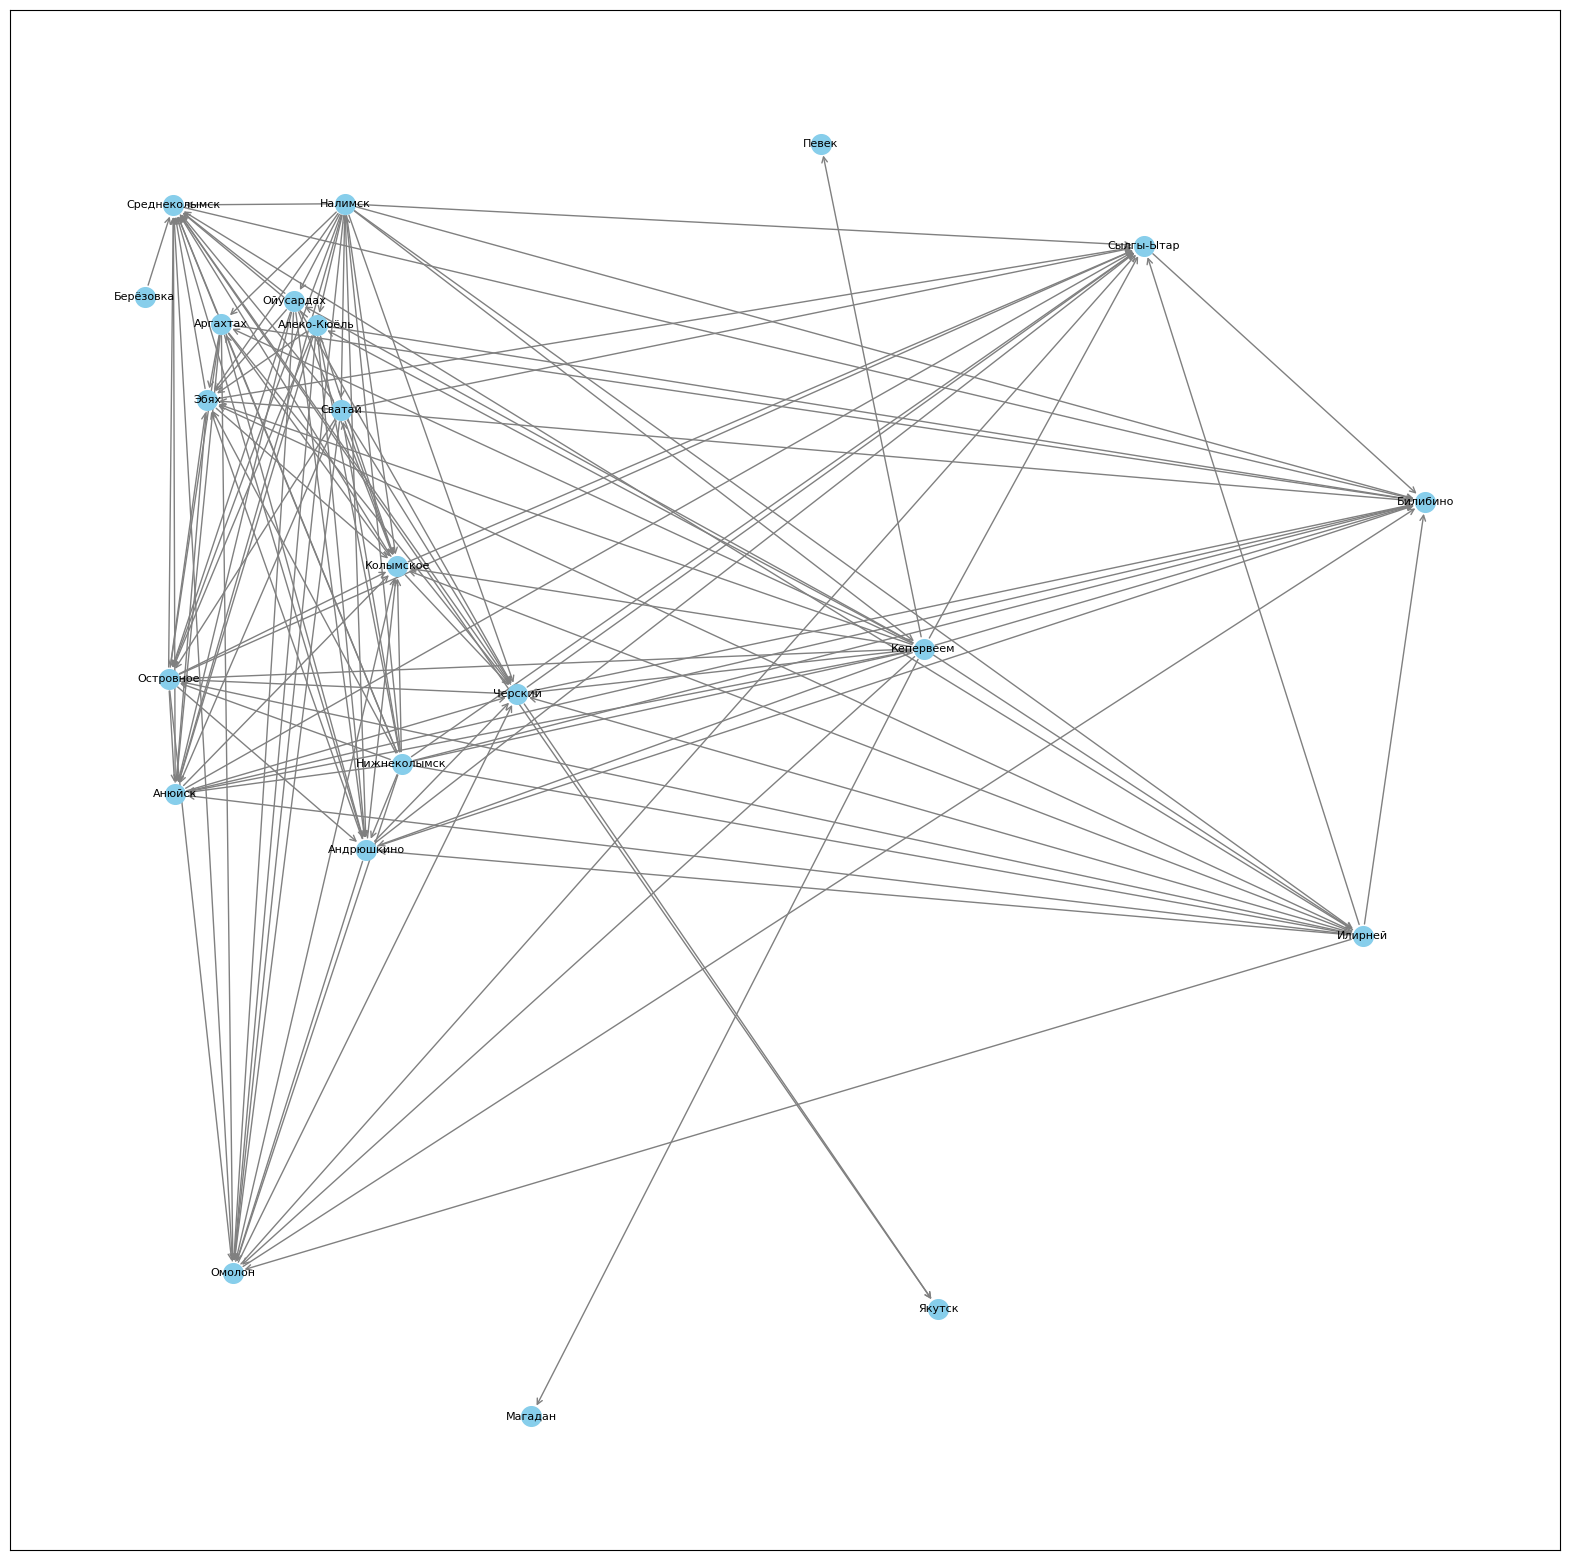

In [ ]:
for _, row in data_graph.iterrows():
    source = row['settl2']  # Начальная вершина
    target = row['settl1']  # Конечная вершина
    gravity_force = row['LocalGravity']

    # Проверяем, чтобы гравитационная сила была ненулевой
    if gravity_force != 0:
        G.add_edge(source, target, weight=gravity_force)

# Настройка параметров для визуализации
pos = nx.spring_layout(G, k=1, scale=3)  # Расположение узлов
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}  # Метки для рёбер
plt.figure(figsize=(20,20))  # Размер графика
nx.draw_networkx_nodes(G, pos, node_size=200, node_color='skyblue')  # Узлы
nx.draw_networkx_edges(G, pos, edge_color='gray', arrowstyle='->', arrows=True)  # Рёбра
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')  # Метки узлов
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)  # Метки рёбер

plt.savefig("graph_warm_G_3.png", format="png")

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
# Получение списка всех узлов
all_nodes = list(G.nodes())
# Подсчет количества входящих рёбер для каждого узла
incoming_counts = {}
for node in all_nodes:
    incoming_count = len(list(G.predecessors(node)))
    incoming_counts[node] = incoming_count

# Получение топ-10 узлов с наибольшим количеством входящих рёбер
top_10_nodes = Counter(incoming_counts).most_common(10)

# Печать результата
for node, count in top_10_nodes:
    print(f"{node}: {count}")

Среднеколымск: 15
Билибино: 13
Колымское: 13
Сылгы-Ытар: 12
Черский: 11
Эбях: 10
Анюйск: 10
Омолон: 10
Островное: 8
Андрюшкино: 8


### Граф по Т

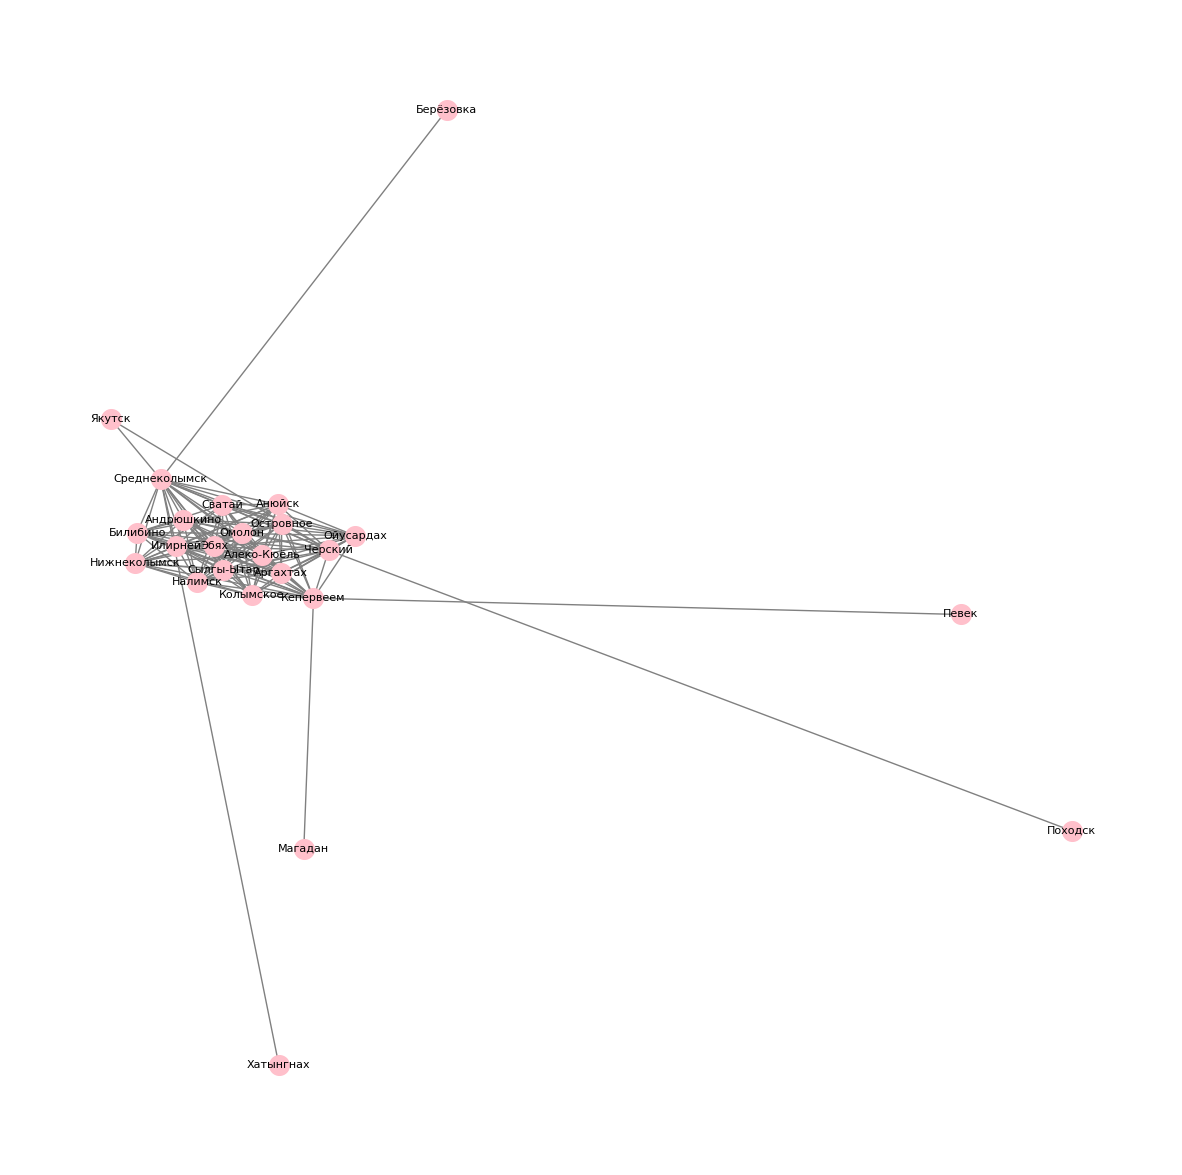

Среднеколымск: 19
Налимск: 17
Кепервеем: 17
Аргахтах: 16
Анюйск: 16
Колымское: 16
Омолон: 16
Островное: 16
Черский: 16
Илирней: 16


In [ ]:
# Чтение данных из CSV-файла
data_graph_time = min_time_cold

# Создаем пустой ненаправленный граф
G_time = nx.Graph()
for _, row in data_graph_time.iterrows():
    settl1 = row['depart']
    settl2 = row['arrival']
    time = row['min']

    # Если время между деревнями не равно нулю, добавляем ребро
    if time != 0:
        G_time.add_edge(settl1, settl2, weight=time)

# Настройка параметров для визуализации
pos_time = nx.spring_layout(G_time, k=1, scale=4)  # Расположение узлов
edge_labels_time = {(u, v): d['weight'] for u, v, d in G_time.edges(data=True)}  # Метки для рёбер
G_time
plt.figure(figsize=(15,15))  # Размер графика
nx.draw_networkx_nodes(G_time, pos_time, node_size=200, node_color='pink')  # Узлы
nx.draw_networkx_edges(G_time, pos_time, edge_color='gray')  # Рёбра
nx.draw_networkx_labels(G_time, pos_time, font_size=8, font_family='sans-serif')  # Метки узлов
#nx.draw_networkx_edge_labels(G_time, pos_time, edge_labels=edge_labels, font_size=10)  # Метки рёбер

#Визуализация
plt.axis('off')
plt.show()
# Подсчет количества рёбер для каждого узла
degree_counts = dict(G_time.degree())

# Получение топ-10 узлов с наибольшим количеством рёбер
top_10_nodes = Counter(degree_counts).most_common(10)

# Печать результата
for node, count in top_10_nodes:
    print(f"{node}: {count}")

### Анализ графа

### Анализ кластеров

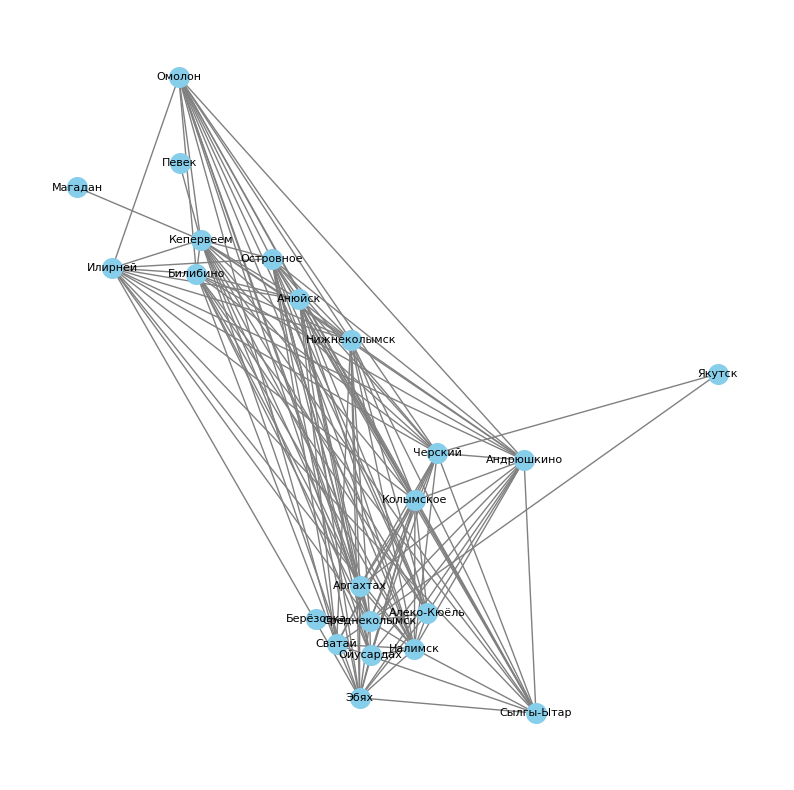

In [ ]:
data_graph_G = sorted_normalized_df
# Создание ненаправленного графа
G_undirect = nx.Graph()

for _, row in data_graph_G.iterrows():
    vertex1 = row['settl1']  # Первая вершина
    vertex2 = row['settl2']  # Вторая вершина
    gravity_force = row['LocalGravity']

    # Проверяем, чтобы гравитационная сила была ненулевой
    if gravity_force != 0:
        G_undirect.add_edge(vertex1, vertex2, weight=gravity_force)
G_undirect
# Настройка параметров для визуализации
pos = nx.spring_layout(G_undirect)  # Расположение узлов
edge_labels = {(u, v): d['weight'] for u, v, d in G_undirect.edges(data=True)}  # Метки для рёбер
plt.figure(figsize=(10,10))  # Размер графика
nx.draw_networkx_nodes(G_undirect, pos, node_size=200, node_color='skyblue')  # Узлы
nx.draw_networkx_edges(G_undirect, pos, edge_color='gray')  # Рёбра
nx.draw_networkx_labels(G_undirect, pos, font_size=8, font_family='sans-serif')  # Метки узлов
#nx.draw_networkx_edge_labels(G_undirect, pos, edge_labels=edge_labels, font_size=10)  # Метки рёбер

#Визуализация
plt.axis('off')
plt.show()

### Обратный граф

In [ ]:
import pandas as pd
# Функция для обработки значений
def  gravity_reverse(x):
    if x == 0:
        return 0
    else:
        return 1 / x

# Применяем функцию к столбцу 'Цена'
df_reverse = sorted_normalized_df.copy()
df_reverse['reverse_gravity'] = df_reverse['LocalGravity'].apply(gravity_reverse)

columns_to_drop = ['LocalGravity']
df_reverse.drop(columns_to_drop, axis=1, inplace=True)
#df_reverse.sort_values(by='reverse_gravity', ascending=False)

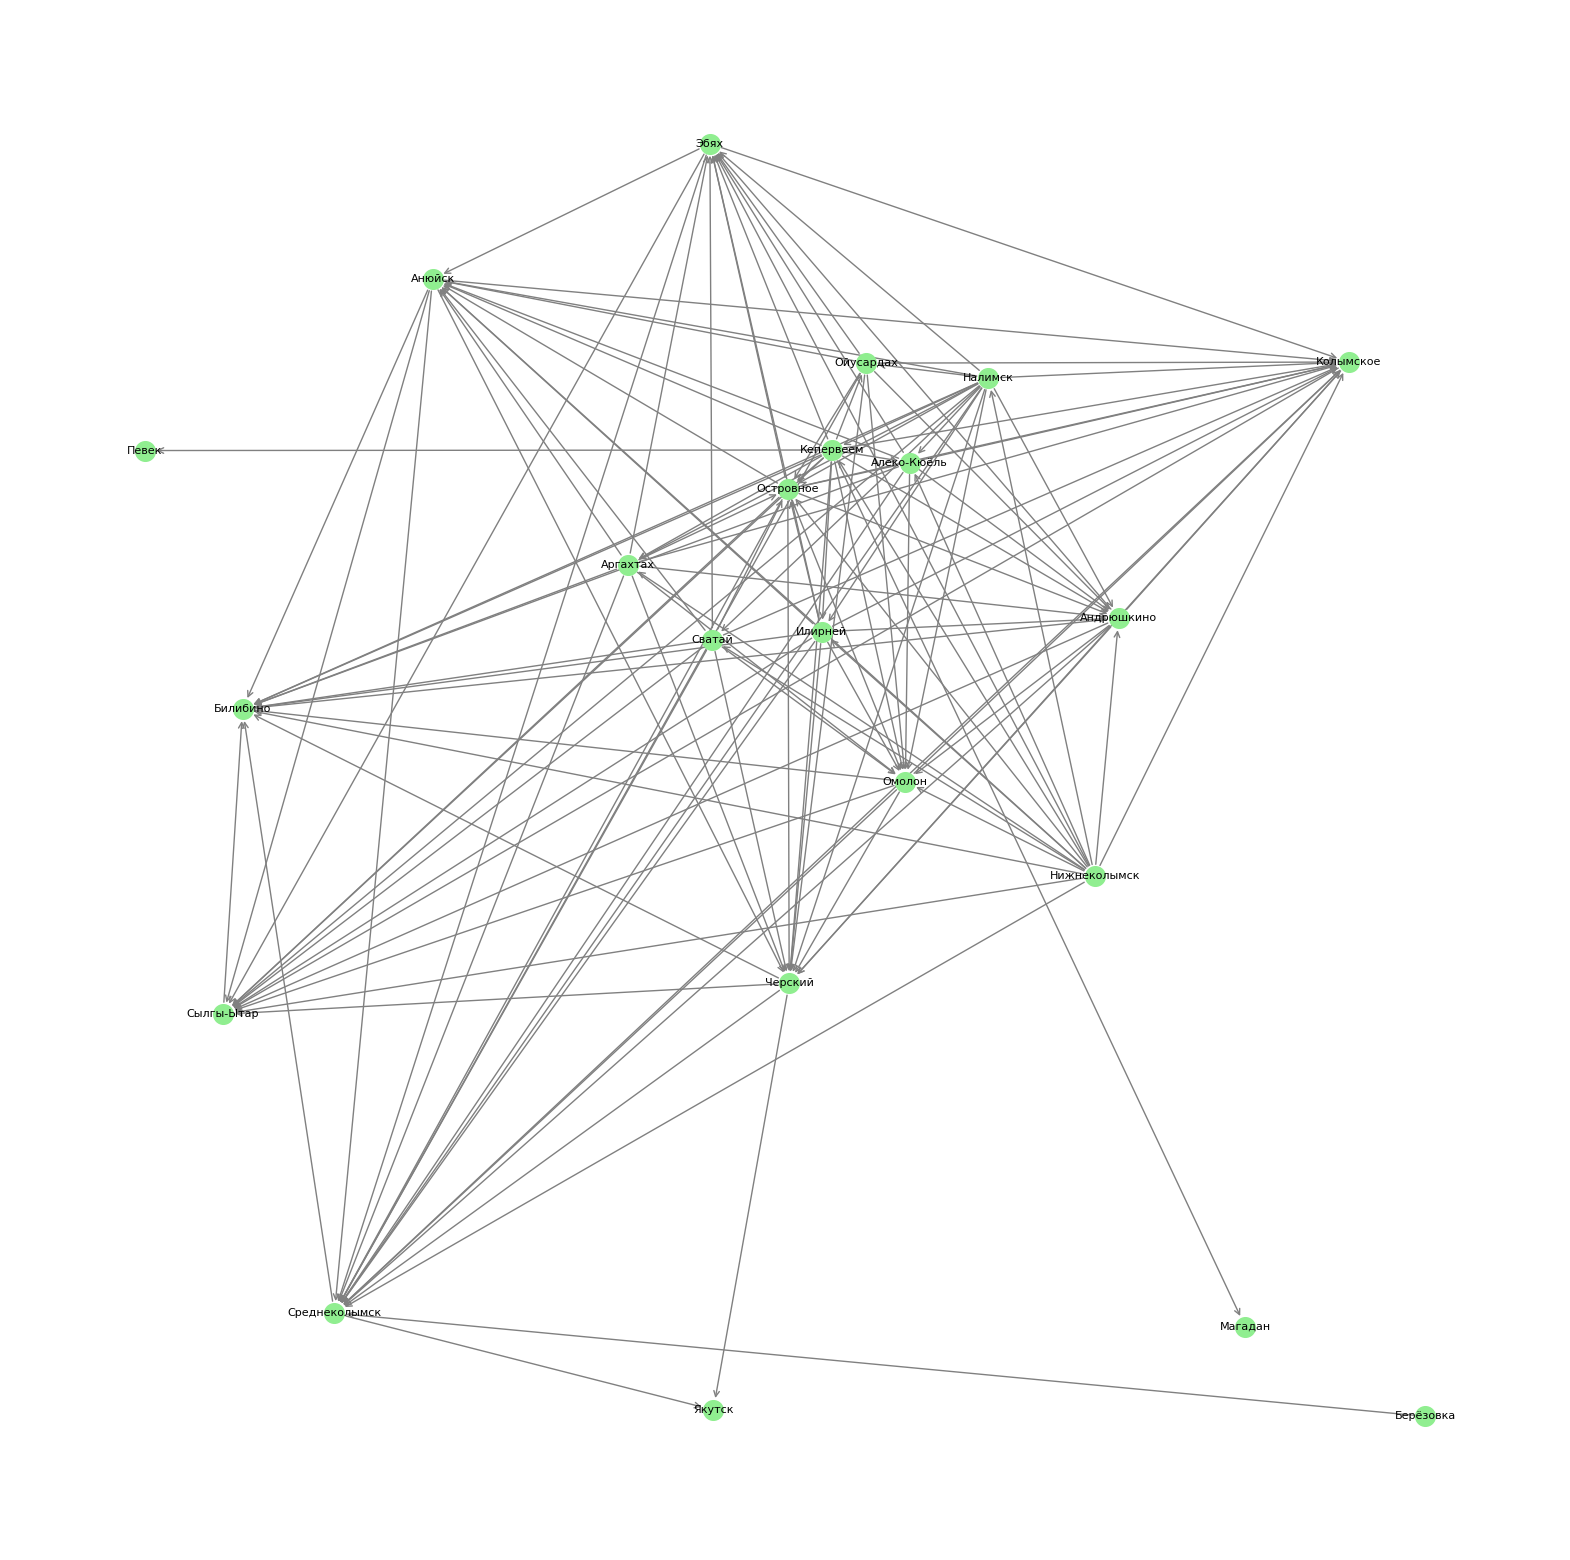

In [ ]:
#Граф с обратным G (то есть 1/G)
data_reverse = df_reverse
# Создание направленного графа
G_reverse = nx.DiGraph()
for _, row in data_reverse.iterrows():
    source = row['settl2']  # Начальная вершина
    target = row['settl1']  # Конечная вершина
    gravity_force = row['reverse_gravity']

    # Проверяем, чтобы гравитационная сила была ненулевой
    if gravity_force != 0:
        G_reverse.add_edge(source, target, weight=gravity_force)

# Настройка параметров для визуализации
pos = nx.spring_layout(G_reverse, k=4, scale=4)  # Расположение узлов
edge_labels = {(u, v): d['weight'] for u, v, d in G_reverse.edges(data=True)}  # Метки для рёбер
plt.figure(figsize=(20,20))  # Размер графика
nx.draw_networkx_nodes(G_reverse, pos, node_size=200, node_color='lightgreen')  # Узлы
nx.draw_networkx_edges(G_reverse, pos, edge_color='gray', arrowstyle='->', arrows=True)  # Рёбра
nx.draw_networkx_labels(G_reverse, pos, font_size=8, font_family='sans-serif')  # Метки узлов
#nx.draw_networkx_edge_labels(G_reverse, pos, edge_labels=edge_labels, font_size=10)  # Метки рёбер

#Визуализация
plt.axis('off')
plt.show()

### Кластеризация

In [ ]:
# Выполнение модулярной кластеризации. мера качества разбиения графа на сообщества. Она позволяет находить группы узлов, внутри которых связи сильнее, чем снаружи.
partition = cl.best_partition(G_undirect)
mod = cl.modularity(partition, G_undirect)

print("Модулярность:", mod)

# Распечатка сообществ
communities = {}
for node, com_id in partition.items():
    if com_id not in communities:
        communities[com_id] = []
    communities[com_id].append(node)

for com_id, nodes in communities.items():
    print(f"Сообщество {com_id + 1}: {', '.join(nodes)}")

Модулярность: 0.45355845249483995
Сообщество 1: Среднеколымск, Ойусардах, Сватай, Аргахтах, Налимск, Берёзовка, Алеко-Кюёль, Эбях, Сылгы-Ытар
Сообщество 2: Билибино, Кепервеем, Анюйск, Островное, Нижнеколымск, Певек, Илирней, Магадан, Омолон
Сообщество 3: Черский, Колымское, Андрюшкино, Якутск


In [ ]:
from networkx.algorithms.centrality import degree_centrality

communities = partition.values()
community_centers = {}

for comm_id in set(communities):
    nodes_in_comm = [node for node, c in partition.items() if c == comm_id]
    degrees = {node: G_undirect.degree(node) for node in nodes_in_comm}
    center = max(degrees, key=degrees.get)
    community_centers[comm_id] = center
print("Центры сообществ:", community_centers)

Центры сообществ: {0: 'Среднеколымск', 1: 'Кепервеем', 2: 'Колымское'}


### Выявление частовстречаемых поселений

In [ ]:
# Расчёт степенной центральности
degree = nx.degree_centrality(G)

# Сортируем населённые пункты по уменьшению степенной центральности
sorted_centralities = sorted(degree.items(), key=lambda x: x[1], reverse=True)

# Вывод результатов
for node, centrality in sorted_centralities:
    print(f"{node}: {centrality:.4f}")

Среднеколымск: 0.8095
Кепервеем: 0.8095
Налимск: 0.8095
Колымское: 0.7619
Островное: 0.7619
Черский: 0.7143
Анюйск: 0.7143
Нижнеколымск: 0.7143
Андрюшкино: 0.7143
Омолон: 0.7143
Эбях: 0.6667
Билибино: 0.6190
Илирней: 0.6190
Сылгы-Ытар: 0.6190
Аргахтах: 0.5714
Сватай: 0.5238
Алеко-Кюёль: 0.5238
Ойусардах: 0.4762
Якутск: 0.0952
Берёзовка: 0.0476
Певек: 0.0476
Магадан: 0.0476


In [ ]:
#Вершины на концах мостов. Критичны для удаления
bridges = list(nx.bridges(G_undirect))
bridge_nodes = set([u for u, _ in bridges] + [v for _, v in bridges])
print(bridge_nodes)

{'Кепервеем', 'Магадан', 'Певек', 'Среднеколымск', 'Берёзовка'}


In [ ]:
# Вычисляем промежуточную центральность для каждого узла. Центральность по промежуточности, показывает, насколько часто узел находится на кратчайших путях между другими узлами графа
bc = nx.betweenness_centrality(G_reverse, normalized=False)
sorted_bc = sorted(bc.items(), key=lambda item: item[1], reverse=True)
important_nodes_bc = [k for k, v in sorted_bc[:7]]
print(important_nodes_bc)

['Среднеколымск', 'Черский', 'Кепервеем', 'Анюйск', 'Островное', 'Эбях', 'Колымское']


In [ ]:
#Центральность по близости, показывает, насколько быстро можно достичь всех других узлов графа из данного узла. Можно оценить, насколько населенный пункт является "опорным" с точки зрения доступности остальных точек
cc = nx.closeness_centrality(G_reverse)
sorted_cc = sorted(cc.items(), key=lambda item: item[1], reverse=True)
important_nodes_cc = [k for k, v in sorted_cc[:7]]
print(important_nodes_cc)

['Среднеколымск', 'Билибино', 'Колымское', 'Сылгы-Ытар', 'Черский', 'Анюйск', 'Эбях']


In [ ]:
from collections import Counter
def sort_nodes_by_frequency(degree_centrality, closeness_centrality, betweenness_centrality, bridge_endpoints):
    # Преобразуем множества в списки, если они таковыми являются
    if isinstance(degree_centrality, set):
        degree_centrality = list(degree_centrality)
    if isinstance(closeness_centrality, set):
        closeness_centrality = list(closeness_centrality)
    if isinstance(betweenness_centrality, set):
        betweenness_centrality = list(betweenness_centrality)
    if isinstance(bridge_endpoints, set):
        bridge_endpoints = list(bridge_endpoints)

    # Объединяем все списки узлов в один большой список
    all_nodes = degree_centrality + closeness_centrality + betweenness_centrality + bridge_endpoints

    # Подсчитываем частоту встречаемости каждого узла
    node_counts = Counter(all_nodes)

    # Сортируем узлы по убыванию частоты
    sorted_nodes = sorted(node_counts.items(), key=lambda x: (-x[1], x[0]))

    return sorted_nodes

sorted_list = sort_nodes_by_frequency(hubs, important_nodes_cc, important_nodes_bc, bridge_nodes)
print(sorted_list)

[('Среднеколымск', 4), ('Анюйск', 3), ('Кепервеем', 3), ('Колымское', 3), ('Черский', 3), ('Островное', 2), ('Эбях', 2), ('Берёзовка', 1), ('Билибино', 1), ('Магадан', 1), ('Налимск', 1), ('Певек', 1), ('Сылгы-Ытар', 1)]


### Поиск минимального остовного дерева (толька на ненаправленных графах)

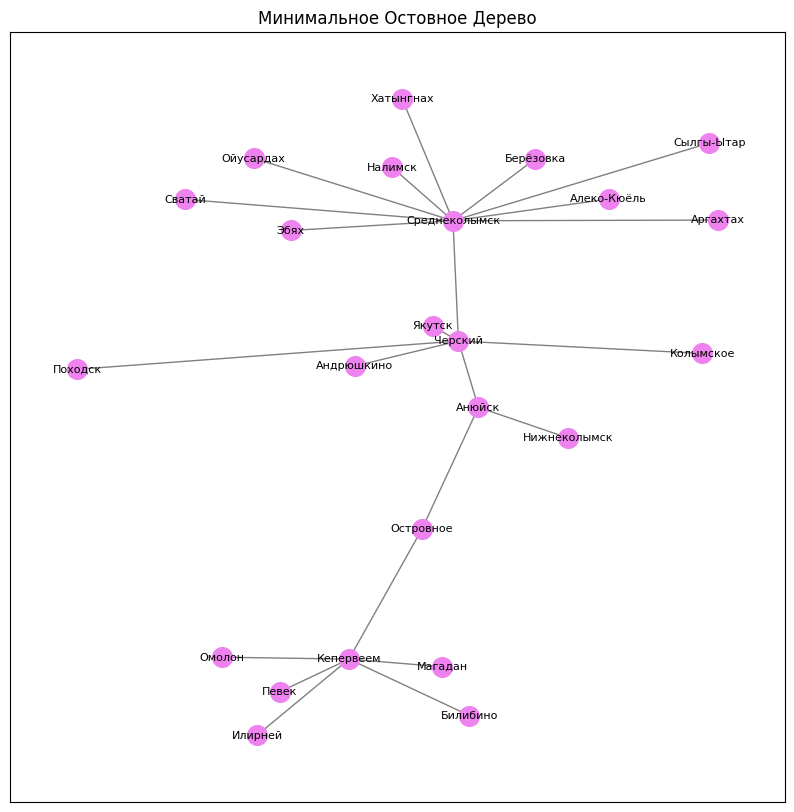

In [ ]:
# Находим минимальное остовное дерево с помощью алгоритма Буравка
MST = nx.minimum_spanning_tree(G_time, algorithm='boruvka')
# Визуализация минимального остовного дерева
pos_MST = nx.spring_layout(MST)  # Расположение вершин
labels = nx.get_edge_attributes(MST, 'weight')  # Вес каждого ребра
plt.figure(figsize=(10, 10))  # Размер графика
# Настройка параметров для визуализации
pos_MST = nx.spring_layout(MST)  # Расположение узлов
nx.draw_networkx_nodes(MST, pos_MST, node_size=200, node_color='violet')  # Узлы
nx.draw_networkx_edges(MST, pos_MST, edge_color='gray')  # Рёбра
nx.draw_networkx_labels(MST, pos_MST, font_size=8, font_family='sans-serif')  # Метки узлов
#nx.draw_networkx_edge_labels(MST, pos_MST, edge_labels=edge_labels, font_size=10)  # Метки рёбер

plt.title('Минимальное Остовное Дерево')
plt.show()

### Определение узлов-стоков и узлов-источников

In [ ]:
#Определение узлов без входящих/исходящих рёбер (только для направленных графов)
def find_sources_and_sinks(G):
    sources = []
    sinks = []

    # Проверяем каждую вершину
    for node in G.nodes():
        has_incoming_edge = False
        has_outgoing_edge = False

        # Проверка наличия входящих рёбер
        for other_node in G.predecessors(node):
            has_incoming_edge = True
            break

        # Проверка наличия исходящих рёбер
        if len(list(G.successors(node))) > 0:
            has_outgoing_edge = True

        # Добавляем вершину в соответствующий список
        if not has_incoming_edge:
            sources.append(node)
        if not has_outgoing_edge:
            sinks.append(node)

    return sources, sinks

# Получение результатов
sources, sinks = find_sources_and_sinks(G)
print("Sources:", sources)
print("Sinks:", sinks)

# Сравнение графов

In [ ]:
#Сравнение двух направленных графов
def compare_digraphs(G_old, G_new):
    # Степенная центральность узлов
    degree_centrality_old = nx.degree_centrality(G_old)
    degree_centrality_new = nx.degree_centrality(G_new)

    # Минимальное остовное дерево
    mst_old = nx.minimum_spanning_tree(G_old.to_undirected())
    mst_new = nx.minimum_spanning_tree(G_new.to_undirected())

    # Количество компонент слабой связности
    weakly_connected_components_old = list(nx.weakly_connected_components(G_old))
    weakly_connected_components_new = list(nx.weakly_connected_components(G_new))

    # Количество узлов только с входящими/выходящими рёбрами
    only_incoming_nodes_old = [node for node, out_degree in G_old.out_degree() if out_degree == 0]
    only_outgoing_nodes_old = [node for node, in_degree in G_old.in_degree() if in_degree == 0]

    only_incoming_nodes_new = [node for node, out_degree in G_new.out_degree() if out_degree == 0]
    only_outgoing_nodes_new = [node for node, in_degree in G_new.in_degree() if in_degree == 0]

    # Вывод результатов
    print("Степенная центральность:")
    sorted_nodes = sorted(set(degree_centrality_old.keys()) | set(degree_centrality_new.keys()), key=lambda x: -(degree_centrality_old.get(x, 0) + degree_centrality_new.get(x, 0)))
    for node in sorted_nodes:
        old_value = degree_centrality_old.get(node, None)
        new_value = degree_centrality_new.get(node, None)
        print(f"{node}: старый граф - {old_value}, новый граф - {new_value}")

    print("\nМинимальные остовные деревья:")
    print(f"Старый граф: {mst_old.edges()}")
    print(f"Новый граф: {mst_new.edges()}")

    print("\nКоличество компонент слабой связности:")
    print(f"Старый граф: {len(weakly_connected_components_old)}")
    print(f"Новый граф: {len(weakly_connected_components_new)}")

    print("\nКоличество узлов только с входящими рёбрами:")
    print(f"Старый граф: {only_incoming_nodes_old}")
    print(f"Новый граф: {only_incoming_nodes_new}")

    print("\nКоличество узлов только с выходящими рёбрами:")
    print(f"Старый граф: {only_outgoing_nodes_old}")
    print(f"Новый граф: {only_outgoing_nodes_new}")

compare_digraphs(G, G_deleted)